# Testing AWaRe on glitch data from GravitySpy

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 30
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return o


In [3]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


# Defining functions to preprocessing the data

In [4]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 10
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


# Defining custom classes

In [6]:
class TimeDistributedMultiHeadAttention(tf.keras.layers.Layer):
        def __init__(self, num_heads, key_dim, **kwargs):
            super().__init__(**kwargs)
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        def call(self, inputs):
            # Use tf.shape for dynamic shape and inputs.shape for static shape
            shape = tf.shape(inputs)
            static_shape = inputs.shape
            batch_size, num_subsequences, subsequence_length = shape[0], static_shape[1], static_shape[2]
            features = static_shape[3]

            reshaped_inputs = tf.reshape(inputs, [-1, subsequence_length, features])

            # Apply multi-head attention to each subsequence individually
            attention_output = self.multi_head_attention(reshaped_inputs, reshaped_inputs)

            # Reshape the output back to the original input shape
            output_shape = [-1, num_subsequences, subsequence_length, features]
            return tf.reshape(attention_output, output_shape)

        def compute_output_shape(self, input_shape):
            return input_shape
        
        def get_config(self):
            config = super().get_config()
            config.update({
                'num_heads': self.num_heads,
                'key_dim': self.key_dim
            })
            return config


# Read glitch data

In [8]:
f1 = h5py.File('Glitch_data/combined_strains_snr_blip_whitened_1.hdf5', 'r')

noise_strain_blip = f1['Strain'][()]
noise_strain_blip_norm, maximum, minimum = _preprocess_data(noise_strain_blip, noise_strain_blip.shape[0], 2048)
noise_strain_blip_norm = np.array(noise_strain_blip_norm)
noise_strain_blip_norm.shape


(92, 2049)

In [9]:
f2 = h5py.File('Glitch_data/combined_strains_snr_koi_fish_whitened.hdf5', 'r')

noise_strain_koi_fish = f2['Strain'][()]
noise_strain_koi_fish_norm, maximum, minimum = _preprocess_data(noise_strain_koi_fish, noise_strain_koi_fish.shape[0], 2048)
noise_strain_koi_fish_norm = np.array(noise_strain_koi_fish_norm)
noise_strain_koi_fish_norm.shape

f3 = h5py.File('Glitch_data/combined_strains_snr_low_freq_burst_whitened_1.hdf5', 'r')

noise_strain_low_freq_burst = f3['Strain'][()]
noise_strain_low_freq_burst_norm, maximum, minimum = _preprocess_data(noise_strain_low_freq_burst, noise_strain_low_freq_burst.shape[0], 2048)
noise_strain_low_freq_burst_norm = np.array(noise_strain_low_freq_burst_norm)
noise_strain_low_freq_burst_norm.shape

f4 = h5py.File('Glitch_data/combined_strains_snr_whistle_whitened_1.hdf5', 'r')

noise_strain_whistle = f4['Strain'][()]
noise_strain_whistle_norm, maximum, minimum = _preprocess_data(noise_strain_whistle, noise_strain_whistle.shape[0], 2048)
noise_strain_whistle_norm = np.array(noise_strain_whistle_norm)
noise_strain_whistle_norm.shape

f5 = h5py.File('Glitch_data/combined_strains_snr_scattered_light_whitened_1.hdf5', 'r')

noise_strain_scattered_light = f5['Strain'][()]
noise_strain_scattered_light_norm, maximum, minimum = _preprocess_data(noise_strain_scattered_light, noise_strain_scattered_light.shape[0], 2048)
noise_strain_scattered_light_norm = np.array(noise_strain_scattered_light_norm)
noise_strain_scattered_light_norm.shape


(27, 2048)

# Read glitch SNR

In [10]:
snr_blip = f1['SNR'][()]
snr_koi_fish = f2['SNR'][()]
snr_low_freq_burst = f3['SNR'][()]
snr_whistle = f4['SNR'][()]
snr_scattered_light = f5['SNR'][()]

# Preparaing data to be applied to network for testing

In [11]:
X_test_noise_blip = reshape_sequences(noise_strain_blip_norm.shape[0], noise_strain_blip)
X_test_noise_koi_fish = reshape_sequences(noise_strain_koi_fish_norm.shape[0], noise_strain_koi_fish)
X_test_noise_low_freq_burst = reshape_sequences(noise_strain_low_freq_burst_norm.shape[0], noise_strain_low_freq_burst)
X_test_noise_whistle = reshape_sequences(noise_strain_whistle_norm.shape[0], noise_strain_whistle)
X_test_noise_scattered_light = reshape_sequences(noise_strain_scattered_light_norm.shape[0], noise_strain_scattered_light)

# Reshape arrays to fit into Keras model
X_test_noise_blip = X_test_noise_blip[:,0:2058,:,None]
print('x_test_strain_blip shape:', X_test_noise_blip.shape)
X_test_noise_blip = X_test_noise_blip.astype("float32")

# Reshape arrays to fit into Keras model
X_test_noise_koi_fish = X_test_noise_koi_fish[:,:,:,None]
print('x_test_strain_koi_fish shape:', X_test_noise_koi_fish.shape)
X_test_noise_koi_fish = X_test_noise_koi_fish.astype("float32")

# Reshape arrays to fit into Keras model
X_test_noise_low_freq_burst = X_test_noise_low_freq_burst[:,:,:,None]
print('x_test_strain_low_freq_burst shape:', X_test_noise_low_freq_burst.shape)
X_test_noise_low_freq_burst = X_test_noise_low_freq_burst.astype("float32")

# Reshape arrays to fit into Keras model
X_test_noise_whistle = X_test_noise_whistle[:,0:2058,:,None]
print('x_test_strain_whistle shape:', X_test_noise_whistle.shape)
X_test_noise_whistle = X_test_noise_whistle.astype("float32")

# Reshape arrays to fit into Keras model
X_test_noise_scattered_light = X_test_noise_scattered_light[:,:,:,None]
print('x_test_strain_scattered_light shape:', X_test_noise_scattered_light.shape)
X_test_noise_scattered_light = X_test_noise_scattered_light.astype("float32")


x_test_strain_blip shape: (92, 2058, 10, 1)
x_test_strain_koi_fish shape: (18, 2058, 10, 1)
x_test_strain_low_freq_burst shape: (42, 2058, 10, 1)
x_test_strain_whistle shape: (78, 2058, 10, 1)
x_test_strain_scattered_light shape: (27, 2058, 10, 1)


# Importing trained model

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp

class NegativeLogLikelihood:
    def __call__(self, y, rv_y):
        return -rv_y.log_prob(y)

negloglik = NegativeLogLikelihood()

model = tf.keras.models.load_model('../model/Saved_models/Trained_model.h5', custom_objects={'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention, 'IndependentNormal': tfp.layers.IndependentNormal,'negloglik': negloglik})


# Testing glitches on trained model

In [17]:
distribution_blip = model(X_test_noise_blip)
    
# Extract mean and standard deviation from the distribution
mean_preds_blip = distribution_blip.mean()*100.0
std_preds_blip = distribution_blip.stddev()*100.0
 
mean_preds_blip = mean_preds_blip.numpy().squeeze()
std_preds_blip = std_preds_blip.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90_blip = mean_preds_blip - 1.645 * std_preds_blip
upper_bound_90_blip = mean_preds_blip + 1.645 * std_preds_blip

lower_bound_50_blip = mean_preds_blip - 0.6745 * std_preds_blip
upper_bound_50_blip = mean_preds_blip + 0.6745 * std_preds_blip


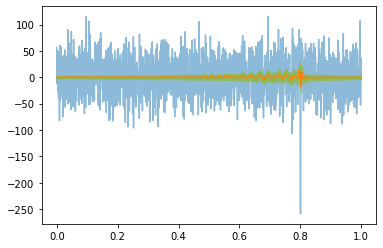

In [26]:
f1 = h5py.File('Glitch_data/combined_strains_snr_blip_whitened_1.hdf5', 'r')

blip_strain = f1['Strain'][()]

time = np.linspace(0, 1.0, 2048)

plt.plot(time, blip_strain[0][0:2048], alpha=0.5)
plt.plot(time, mean_preds_blip[0][0:2048])
plt.fill_between(time, lower_bound_90_blip[0][0:2048], upper_bound_90_blip[0][0:2048], color='yellow')

In [27]:
distribution_koi_fish = model(X_test_noise_koi_fish)
    
# Extract mean and standard deviation from the distribution
mean_preds_koi_fish = distribution_koi_fish.mean()*100.0
std_preds_koi_fish = distribution_koi_fish.stddev()*100.0
 
mean_preds_koi_fish = mean_preds_koi_fish.numpy().squeeze()
std_preds_koi_fish= std_preds_koi_fish.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90_koi_fish = mean_preds_koi_fish - 1.645 * std_preds_koi_fish
upper_bound_90_koi_fish = mean_preds_koi_fish + 1.645 * std_preds_koi_fish

lower_bound_50_koi_fish = mean_preds_koi_fish - 0.6745 * std_preds_koi_fish
upper_bound_50_koi_fish = mean_preds_koi_fish + 0.6745 * std_preds_koi_fish


In [39]:
distribution_low_freq_burst = model(X_test_noise_low_freq_burst)
    
# Extract mean and standard deviation from the distribution
mean_preds_low_freq_burst = distribution_low_freq_burst.mean()*100.0
std_preds_low_freq_burst = distribution_low_freq_burst.stddev()*100.0
 
mean_preds_low_freq_burst = mean_preds_low_freq_burst.numpy().squeeze()
std_preds_low_freq_burst= std_preds_low_freq_burst.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90_low_freq_burst = mean_preds_low_freq_burst - 1.645 * std_preds_low_freq_burst
upper_bound_90_low_freq_burst = mean_preds_low_freq_burst + 1.645 * std_preds_low_freq_burst

lower_bound_50_low_freq_burst = mean_preds_low_freq_burst - 0.6745 * std_preds_low_freq_burst
upper_bound_50_low_freq_burst = mean_preds_low_freq_burst + 0.6745 * std_preds_low_freq_burst


In [40]:
distribution_whistle = model(X_test_noise_whistle)
    
# Extract mean and standard deviation from the distribution
mean_preds_whistle = distribution_whistle.mean()*100.0
std_preds_whistle = distribution_whistle.stddev()*100.0
 
mean_preds_whistle = mean_preds_whistle.numpy().squeeze()
std_preds_whistle = std_preds_whistle.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90_whistle = mean_preds_whistle - 1.645 * std_preds_whistle
upper_bound_90_whistle = mean_preds_whistle + 1.645 * std_preds_whistle

lower_bound_50_whistle = mean_preds_whistle - 0.6745 * std_preds_whistle
upper_bound_50_whistle = mean_preds_whistle + 0.6745 * std_preds_whistle


In [42]:
distribution_scattered_light = model(X_test_noise_scattered_light)
    
# Extract mean and standard deviation from the distribution
mean_preds_scattered_light = distribution_scattered_light.mean()*100.0
std_preds_scattered_light = distribution_scattered_light.stddev()*100.0
 
mean_preds_scattered_light = mean_preds_scattered_light.numpy().squeeze()
std_preds_scattered_light = std_preds_scattered_light.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound_90_scattered_light = mean_preds_scattered_light - 1.645 * std_preds_scattered_light
upper_bound_90_scattered_light = mean_preds_scattered_light + 1.645 * std_preds_scattered_light

lower_bound_50_whistle = mean_preds_scattered_light - 0.6745 * std_preds_scattered_light
upper_bound_50_whistle = mean_preds_scattered_light + 0.6745 * std_preds_scattered_light


# Computing SNR of reconstructions

In [49]:
from pycbc.filter import sigma, sigmasq, matched_filter
from pycbc.types import TimeSeries

snr_denoised_blip = np.array([sigmasq(TimeSeries((signal).astype('float64'), delta_t = 1.0/2048), 
                                    psd=None,low_frequency_cutoff=30.0) for signal in mean_preds_blip])**0.5

snr_denoised_koi_fish = np.array([sigmasq(TimeSeries((signal).astype('float64'), delta_t = 1.0/2048), 
                                    psd=None,low_frequency_cutoff=30.0) for signal in mean_preds_koi_fish])**0.5

snr_denoised_low_freq_burst = np.array([sigmasq(TimeSeries((signal).astype('float64'), delta_t = 1.0/2048), 
                                    psd=None,low_frequency_cutoff=30.0) for signal in mean_preds_low_freq_burst])**0.5

snr_denoised_whistle = np.array([sigmasq(TimeSeries((signal).astype('float64'), delta_t = 1.0/2048), 
                                    psd=None,low_frequency_cutoff=30.0) for signal in mean_preds_whistle])**0.5

snr_denoised_scattered_light = np.array([sigmasq(TimeSeries((signal).astype('float64'), delta_t = 1.0/2048), 
                                    psd=None,low_frequency_cutoff=30.0) for signal in mean_preds_scattered_light])**0.5


# Plotting the recovered vs. glitch SNR

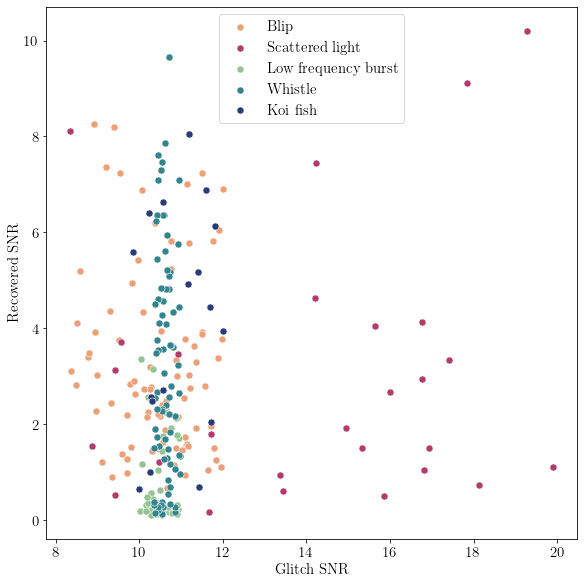

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(8, 8))  # Increased figure size
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

palette_crest = sns.color_palette("crest", n_colors=15)
palette_flare = sns.color_palette("flare", n_colors=15)

# Main scatter plot
sns.scatterplot(x=snr_blip, y=snr_denoised_blip, s=50, color=palette_flare[0], label='Blip', legend=True)
sns.scatterplot(x=snr_scattered_light, y=snr_denoised_scattered_light, s=50, color=palette_flare[8], label='Scattered light', legend=True)
sns.scatterplot(x=snr_low_freq_burst, y=snr_denoised_low_freq_burst, s=50, color=palette_crest[0], label='Low frequency burst', legend=True)
sns.scatterplot(x=snr_whistle, y=snr_denoised_whistle, s=50, color=palette_crest[7], label='Whistle', legend=True)
sns.scatterplot(x=snr_koi_fish, y=snr_denoised_koi_fish, s=50, color=palette_crest[14], label='Koi fish', legend=True)


plt.xlabel('Glitch SNR', fontsize=15)
plt.ylabel('Recovered SNR', fontsize=15)
#plt.ylim(-1,30)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.grid(False)  # Turn off gridlines
plt.legend(fontsize=15)

plt.savefig('Plots/Glitch_test_scatter_plot.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
